In [16]:
using PyPlot

function test_image(ver, m=50, noise=0)
    A = 0.8*ones(Float64, m, m)
    if ver == 1
        i = 1:m
        sc = m/100
        for c in [[50,60,20], [65,60,15], [35,30,15]]
            A = @. max(0.2, A - 0.6*Float64((i - sc*c[1])^2 + (i' - sc*c[2])^2 < (sc*c[3])^2))
        end
    elseif ver == 2
        is = [[25,35,25,35], [65,75,65,75], [65,75,45,50], [40,45,40,70]]
        for i in is
            i = round.(Int, i*m/100)
            A[i[1]:i[2], i[3]:i[4]] .= 0.3
        end
    else
        error("Unknown image version")
    end
    
    A += noise*randn(size(A))
    A = min.(max.(A, 0), 1)
end

test_image (generic function with 3 methods)

These two test images are shown below, with no noise (top row) and with noise of magnitude 0.3 (bottom row).

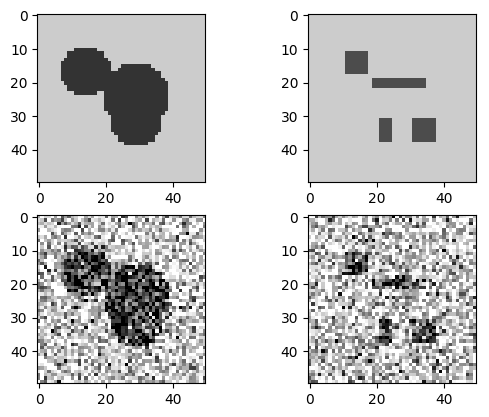

In [17]:
plt = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    plt += 1
    subplot(2,2,plt)
    A = test_image(ver, m, noise)
    imshow(A[:,:,[1,1,1]])
end

In [18]:
function initial_value(sz)
    m,n = sz
    Φ = [sqrt((i - m/2)^2 + (j - n/2)^2) - 0.4n for i = 1:m, j = 1:n]
end

initial_value (generic function with 1 method)

In [20]:
function H(t)
    H = 1/2*(1+2/pi*atan(t))
    return H
end

H (generic function with 1 method)

In [21]:
function δ(t)
    δ = 1/(pi*(t^2+1))
    return δ
end

δ (generic function with 1 method)

In [22]:
function coefficients(Φ, A)
    n = size(A)[1]
    m = size(A)[2]
    c1top = 0
    for i=1:n
        for j = 1:m
            c1top+=A[i,j]*H(Φ[i,j])
        end
    end
    
    c1bot = 0
    for i=1:n
        for j = 1:m
            c1bot+=H(Φ[i,j])
        end
    end
    c1 = c1top/c1bot
    
    c2top = 0
    for i=1:n
        for j = 1:m
            c2top+=A[i,j]*(1-H(Φ[i,j]))
        end
    end
    
    c2bot = 0
    for i=1:n
        for j = 1:m
            c2bot+=(1-H(Φ[i,j]))
        end
    end
    c2 = c2top/c2bot    
    
    return c1, c2
end

coefficients (generic function with 1 method)

In [36]:
function update(Φ, A)
    c1, c2 = coefficients(Φ, A)
    n = size(A)[1]
    m = size(A)[2] 
    
    Φxx = zeros(n, m)
    Φyy = zeros(n, m)
    Φxy = zeros(n, m)
    Φx = zeros(n, m)
    Φy = zeros(n, m)
    κ0 = zeros(n, m)
    κ = zeros(n, m)
    ΔΦ = zeros(n,m)

    for i = 1:n
        for j = 1:m
            if i ==1 || i ==m ||j==1||j==n
                ΔΦ[i,j] = 0
                else
                Φxx[i,j] = Φ[i+1, j]-2*Φ[i,j]+Φ[i-1,j]
                Φyy[i,j] = Φ[i, j+1]-2*Φ[i,j]+Φ[i,j-1]
                Φxy[i,j] = (Φ[i+1, j+1]-Φ[i-1,j+1]-Φ[i+1,j-1]+Φ[i-1,j-1])/4
                Φx[i,j] = (Φ[i+1,j]-Φ[i-1,j])/2
                Φy[i,j] = (Φ[i,j+1]-Φ[i,j-1])/2
                κ0[i,j] = (Φxx[i,j]*Φy[i,j]^2 - 2*Φx[i,j]*Φy[i,j]*Φxy[i,j]+Φyy[i,j]*Φx[i,j]^2)/(((Φx[i,j]^2+Φy[i,j]^2))^(3/2)+10^(-6))
                κ[i,j] = maximum([minimum([κ0[i,j], 5]), -5])                
                ΔΦ[i,j] = 100*δ(Φ[i,j])*(0.2*κ[i,j]-(A[i,j]-c1)^2+(A[i,j]-c2)^2)
                
            end
        end
    end     
    return ΔΦ
end

update (generic function with 1 method)

In [37]:
function image_segment(A; maxiter=10000)
    n = size(A)[1]
    m = size(A)[2]
    sz = size(A)
    Φ=initial_value(sz)
    for i = 1:maxiter
        ΔΦ = update(Φ, A)
        Φ+=ΔΦ
        if maximum(@.abs(ΔΦ))<2*10^(-2) break end
    end
    return Φ
end

image_segment (generic function with 1 method)

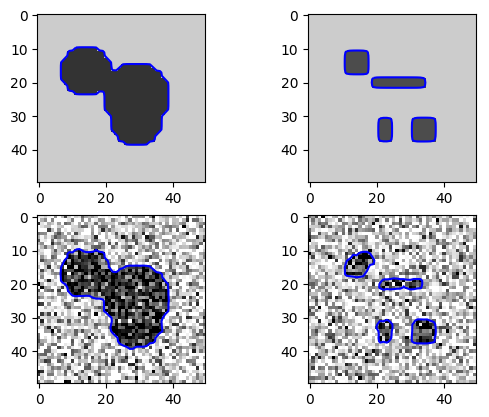

In [38]:
plt = 0
m = 50
for noise = [0, 0.3], ver = 1:2
    plt += 1
    subplot(2,2,plt)
    A = test_image(ver, m, noise)
    Φ = image_segment(A)
    imshow(A[:,:,[1,1,1]])
    contour(Φ, [0.0], colors="b")
end